# 1. Import libraries

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


In [2]:
# Set the paths based on your Drive directory
data_dir ='data' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

# 2. Load and pre-process the dataset

In [3]:
print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")


Data directory: data
Training directory: data/Training
Testing directory: data/Testing


In [4]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.
np.random.seed(seed=42)
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale',
        #seed=seed
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode='grayscale'
    )

    return train_data, test_data

# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# 3. Visualise data and plot data distribution

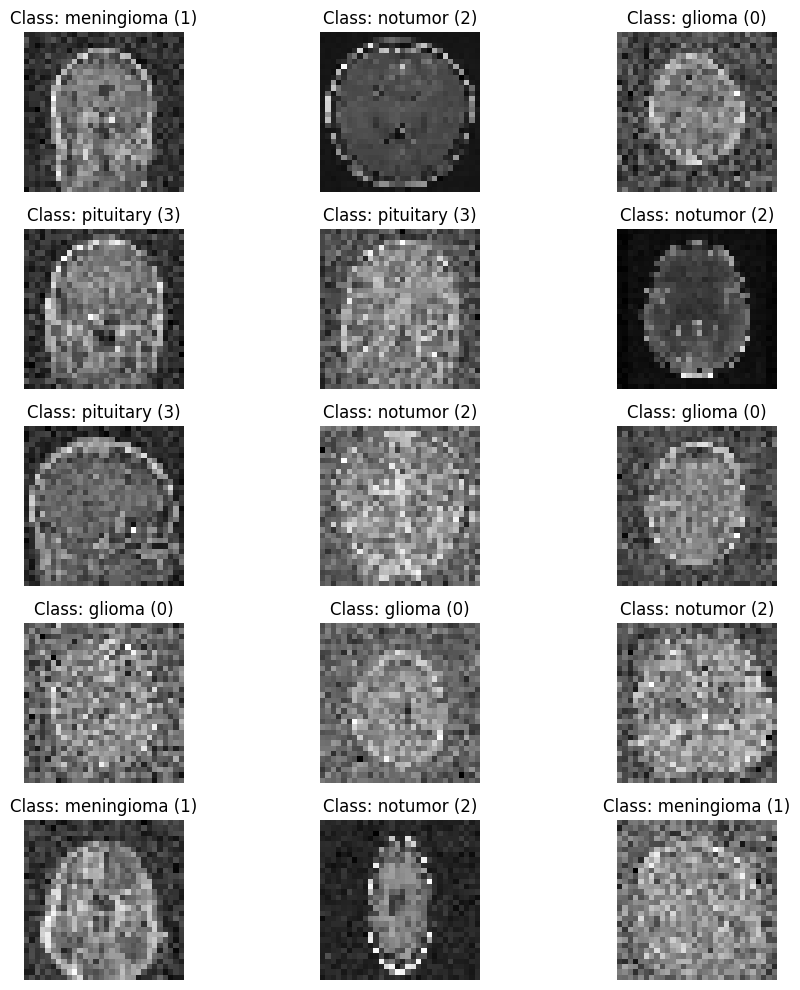

In [5]:
def visualize_batch(df):

    #Iterating through the different batches
    image_batch, label_batch = next(df)

    #Deriving the class names
    class_names = train_data.class_indices

    #Creating 1 figure with 15 subplots
    fig, ax = plt.subplots(nrows= 5, ncols = 3, figsize = (10, 10))

    #Flatten the axis allowing for easier assignment of 'i'
    ax = ax.flatten()
    for i in range(15):

        #For every ax[i], display the image on the index
        ax[i].imshow(image_batch[i], cmap = 'gray')
        ax[i].axis('off')

        #Deriving the class number and class name
        class_number = label_batch[i].argmax()

        #Displaying the class name and its corresponding number
        for name, number in class_names.items():

            #Checking which number corresponds to the class number
            if number == class_number:
                class_name = name
                ax[i].set_title(f'Class: {class_name} ({class_number})')

    plt.tight_layout()
    plt.show()

visualize_batch(train_data)


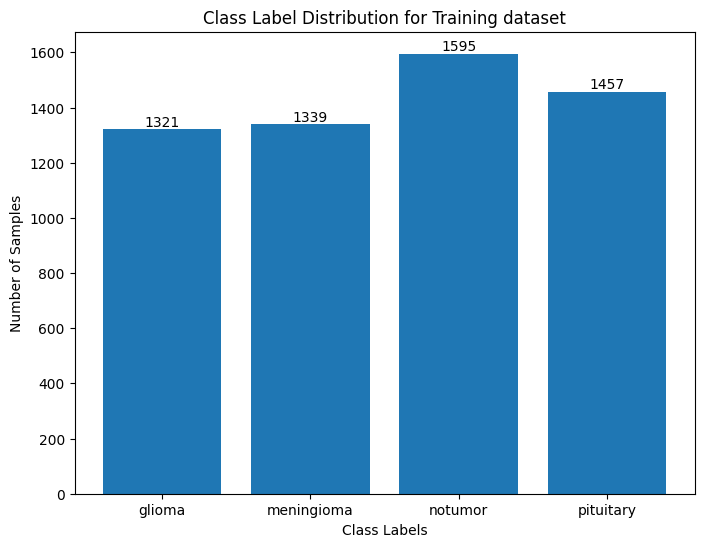

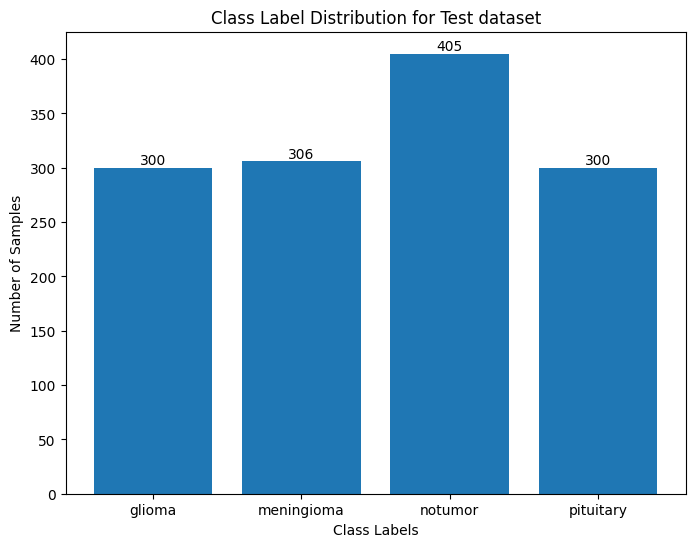

In [6]:
for data in [("Training", train_data), ("Test", test_data)]:
  class_labels = list(data[1].class_indices.keys())

  class_counts = [np.sum(data[1].labels == i) for i in range(len(class_labels))]

  plt.figure(figsize=(8, 6))
  bars = plt.bar(class_labels, class_counts)
  plt.xlabel("Class Labels")
  plt.ylabel("Number of Samples")
  plt.title(f"Class Label Distribution for {data[0]} dataset")

  for bar in bars:
      yval = bar.get_height()
      plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')


# 4. Train and Evaluation functions

In [7]:
def train_val_split(df,val_split = 0.2):
    #Resetting the generator for reproducible results
    df.reset()

    n_batches = df.num_batches
    batch_size = df.batch_size
    n_samples = df.samples

    print(f'Number of batches in the training data: {n_batches}')
    print(f'Batch size of a single batch {batch_size}')
    print(f'Number of samples in the training dataset {n_samples}')
    print()

    #Setting the size of the train and validation set according to the required split and testing if all batches are included
    val_batches = int(n_batches * val_split)
    train_batches = n_batches - val_batches

    print(f'Number of training data batches with val split of {val_split}: {train_batches}')
    print(f'Number of validation data batches: {val_batches}')
    print()
    assert train_batches + val_batches == n_batches, 'Train and val batches do not add up to total n batches'




    #Iterating through the batches and appending them into lists for train and val
    x_train, y_train = list(), list()
    x_val, y_val = list(), list()

    for batch in range(n_batches):
        x, y = next(df)
        if batch < train_batches:
            x_train.append(x)
            y_train.append(y)

        else:
            x_val.append(x)
            y_val.append(y)

    assert len(x_train) + len(x_val) == n_batches, 'Error in dividing batches into train and val sets'


    #Converting the lists into arrays suited for Tensorflow
    x_train = tf.concat(x_train, axis = 0)
    y_train = tf.concat(y_train, axis = 0)
    x_val = tf.concat(x_val, axis = 0)
    y_val = tf.concat(y_val, axis = 0)

    print(f'Shape of image training set: {x_train.shape}')
    print(f'Shape of image validation set: {x_val.shape}')
    print()
    print(f'Shape of label training set: {y_train.shape}')
    print(f'Shape of label validation set: {y_val.shape}')

    #Testing to see if all the samples are included
    assert x_train.shape[0] + x_val.shape[0] == n_samples, 'Error, not all samples included'



    return x_train, y_train, x_val, y_val

X_train, y_train, X_val, y_val = train_val_split(train_data)

Number of batches in the training data: 179
Batch size of a single batch 32
Number of samples in the training dataset 5712

Number of training data batches with val split of 0.2: 144
Number of validation data batches: 35

Shape of image training set: (4608, 30, 30, 1)
Shape of image validation set: (1104, 30, 30, 1)

Shape of label training set: (4608, 4)
Shape of label validation set: (1104, 4)


In [8]:
np.save(f'{data_dir}/X_train.npy', X_train)
np.save(f'{data_dir}/y_train.npy', y_train)
np.save(f'{data_dir}/X_val.npy', X_val)
np.save(f'{data_dir}/y_val.npy', y_val)

print("Training and validation datasets have been saved successfully.")

Training and validation datasets have been saved successfully.


In [9]:
def test_to_numpy(df):
    #Resetting the generator for reproducible results
    df.reset()

    n_batches = df.num_batches
    batch_size = df.batch_size
    n_samples = df.samples

    print(f'Number of batches in the test data: {n_batches}')
    print(f'Batch size of a single batch {batch_size}')
    print(f'Number of samples in the test dataset {n_samples}')
    print()

    #Iterating through the batches and appending them into lists for train and val
    x_test, y_test = list(), list()

    for batch in range(n_batches):
        x, y = next(df)
        x_test.append(x)
        y_test.append(y)

    #Converting the lists into arrays suited for Tensorflow
    x_test = tf.concat(x_test, axis = 0)
    y_test = tf.concat(y_test, axis = 0)

    print(f'Shape of image test set: {x_test.shape}')
    print()
    print(f'Shape of label test set: {y_test.shape}')

    #Testing to see if all the samples are included
    assert  x_test.shape[0] == n_samples, 'Error, not all samples included'
    return x_test, y_test


X_test, y_test = test_to_numpy(test_data)

np.save(f'{data_dir}/X_test.npy', X_test)
np.save(f'{data_dir}/y_test.npy', y_test)

Number of batches in the test data: 41
Batch size of a single batch 32
Number of samples in the test dataset 1311

Shape of image test set: (1311, 30, 30, 1)

Shape of label test set: (1311, 4)


In [10]:
class_names_train = list(train_data.class_indices.keys())

with open(f'{data_dir}/class_names_train.pkl', 'wb') as file:
    pickle.dump(class_names_train, file)


class_names_test = list(test_data.class_indices.keys())

with open(f'{data_dir}/class_names_test.pkl', 'wb') as file:
    pickle.dump(class_names_test, file)

print("Class names have been saved successfully.")

Class names have been saved successfully.
